In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')

# transform timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

### Basic Information

In [3]:
# Display basic information
print("Dataset Basic Information:")
print(df.info())

# Check for missing values
print("\nMissing Values Statistics:")
display(df.isnull().sum())

Dataset Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122438 entries, 0 to 2122437
Data columns (total 11 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   timestamp               datetime64[ns]
 1   open                    float64       
 2   high                    float64       
 3   low                     float64       
 4   close                   float64       
 5   volume                  float64       
 6   quote_asset_volume      float64       
 7   number_of_trades        float64       
 8   taker_buy_base_volume   float64       
 9   taker_buy_quote_volume  float64       
 10  target                  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 178.1 MB
None

Missing Values Statistics:


timestamp                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
number_of_trades          0
taker_buy_base_volume     0
taker_buy_quote_volume    0
target                    0
dtype: int64

In [4]:
# Display basic statistical information
print("Basic Statistical Information:")
display(df.describe())

Basic Statistical Information:


,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
count,2122438,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06,2.122438e+06
mean,2020-05-10 20:59:29.999994880,4.971020e-01,4.976028e-01,4.965936e-01,4.971011e-01,2.484890e+05,1.650106e+05,2.121758e+02,1.237279e+05,8.230815e+04,4.757849e-01
min,2018-05-04 22:01:00,1.057300e-01,1.068400e-01,1.012900e-01,1.058900e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2019-05-08 09:30:15,2.676100e-01,2.678200e-01,2.673900e-01,2.676000e-01,2.498430e+04,7.835293e+03,2.700000e+01,1.083690e+04,3.409231e+03,0.000000e+00
50%,2020-05-10 20:59:30,3.629800e-01,3.633400e-01,3.626000e-01,3.629700e-01,7.833306e+04,2.853193e+04,6.800000e+01,3.622145e+04,1.362004e+04,0.000000e+00
75%,2021-05-14 08:28:45,6.572000e-01,6.579550e-01,6.563000e-01,6.572000e-01,2.334948e+05,1.315786e+05,1.970000e+02,1.145778e+05,6.322541e+04,1.000000e+00
max,2022-05-17 19:58:00,1.964710e+00,1.966890e+00,1.958350e+00,1.964710e+00,6.366178e+07,3.556471e+07,4.053500e+04,3.087021e+07,1.602615e+07,1.000000e+00
std,NaN,3.147919e-01,3.152553e-01,3.143317e-01,3.147945e-01,6.416383e+05,4.887013e+05,5.372650e+02,3.249252e+05,2.488676e+05,4.994134e-01


### Data Visualiztion

Target Variable Distribution:


target
0.0    0.524215
1.0    0.475785
Name: proportion, dtype: float64

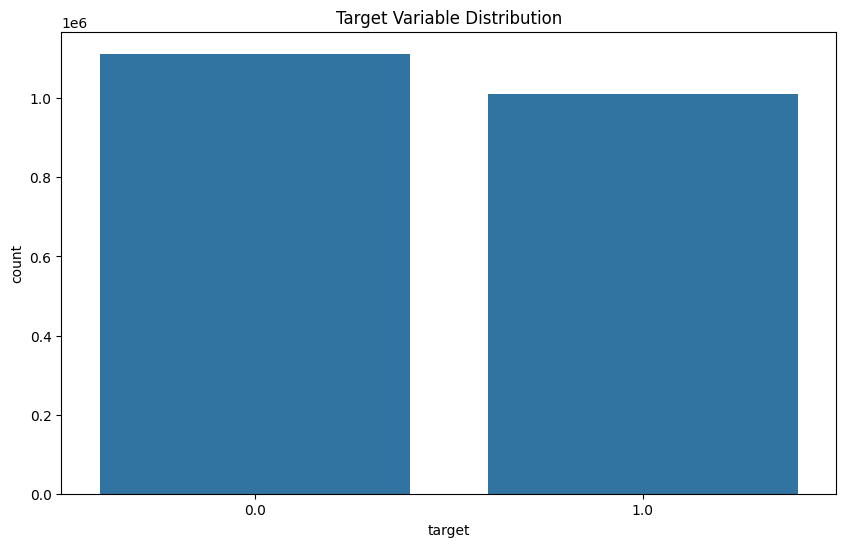

In [5]:
# The distribution of the target variable -> A little bit unbalanced, but not too bad
target_dist = df['target'].value_counts(normalize=True)
print("Target Variable Distribution:")
display(target_dist)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title("Target Variable Distribution")
plt.show()

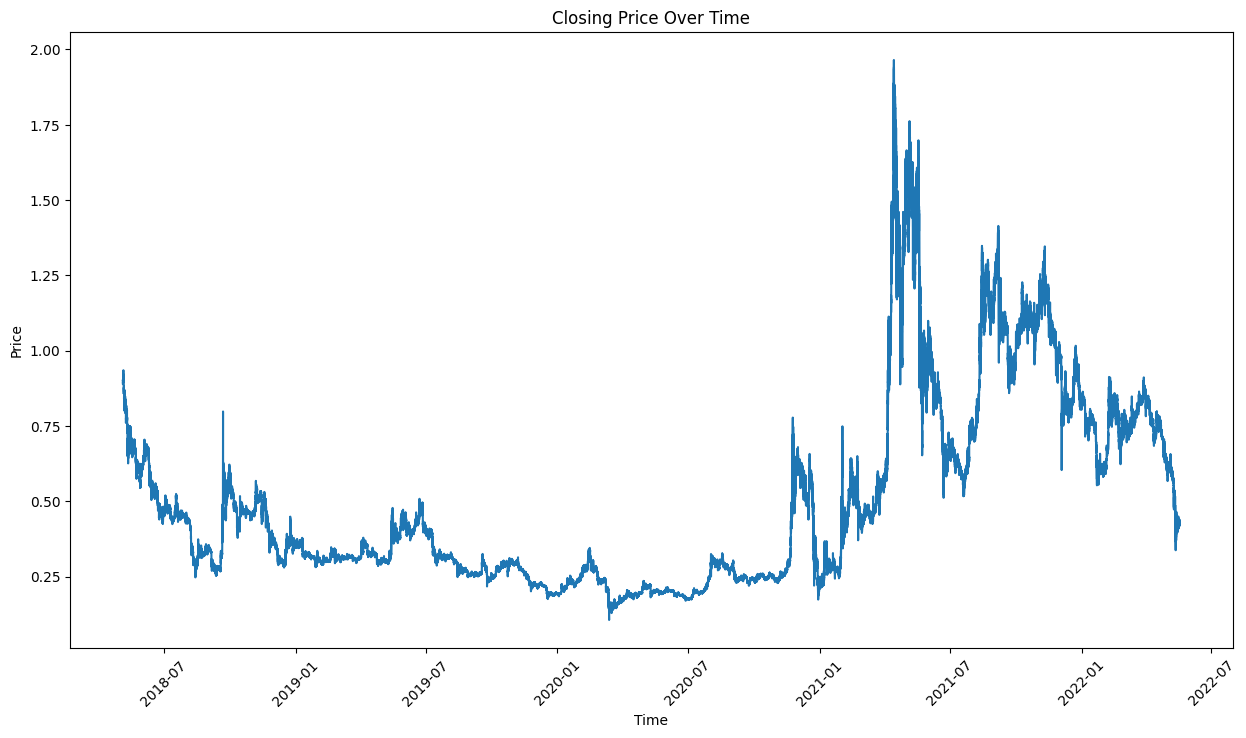

In [6]:
# Price trend
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['close'])
plt.title('Closing Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

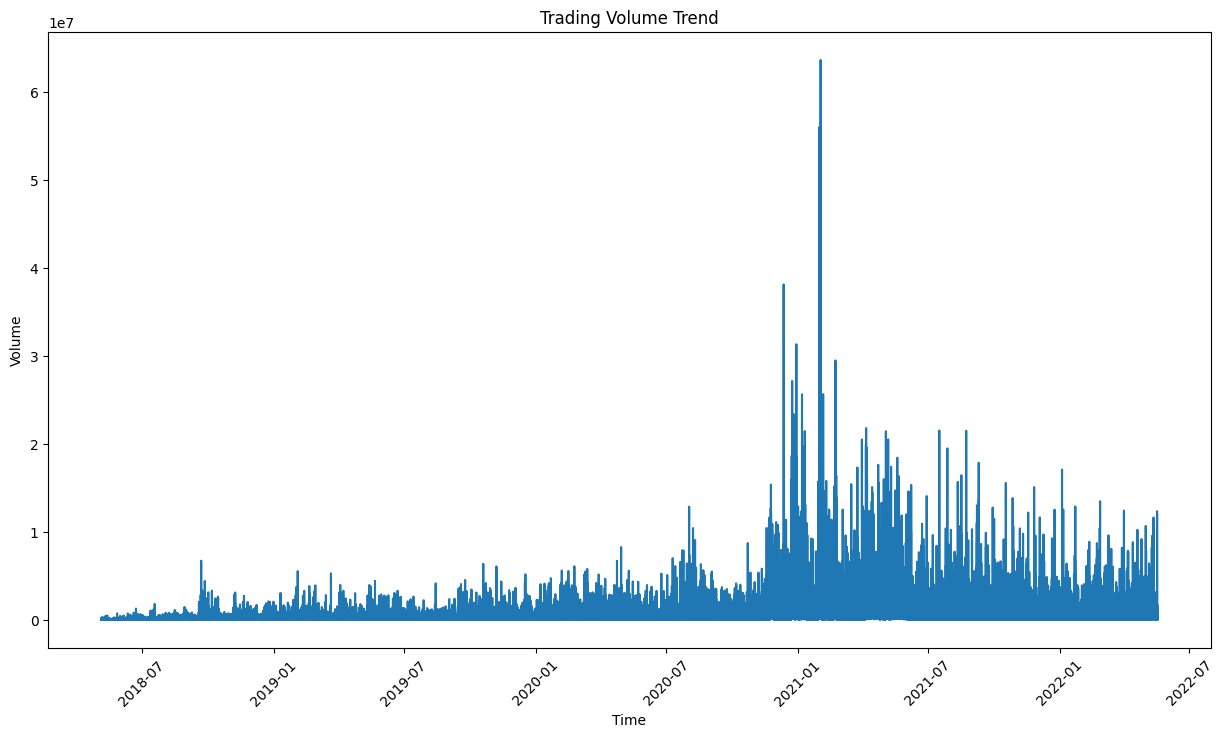

In [7]:
# Trading Volume Trend
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['volume'])
plt.title("Trading Volume Trend")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.show()

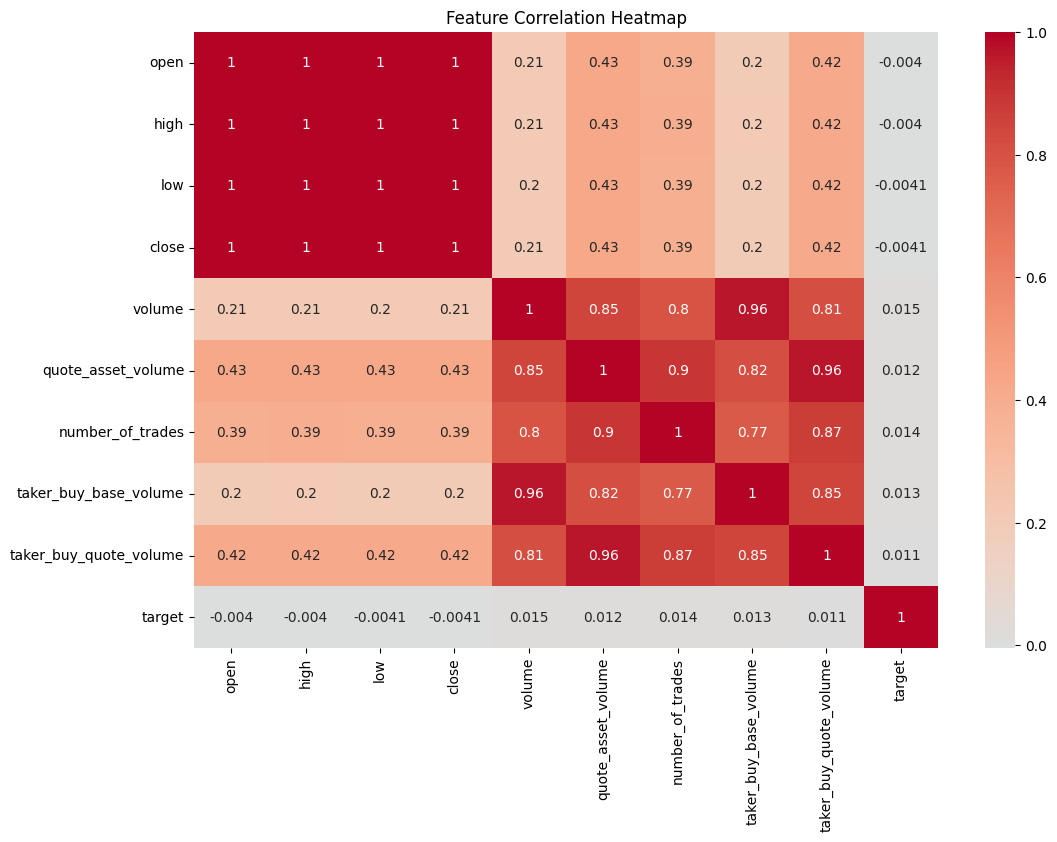

In [8]:
# Calculate the correlation matrix -> high correlation between some of them -> using PCA to reduce dimensionality
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

進行股票常見指標計算：RSI、布林帶等技術指標。

切分訓練集、驗證集。 

針對訓練集資料點進行異常值偵測，刪除異常值。 

進行特徵轉換：標準化和正規化並變成常態分佈（僅根據訓練集計算參數）。 

降維：使用 PCA 保留重要特徵（僅在訓練集上計算降維轉換）。 

### Data Preprocessing

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List, Union, Tuple, Dict

class StockFeatureGenerator:
    def __init__(self, window_sizes: List[int] = [5, 10, 15, 30, 60]):
        """
        初始化特徵產生器
        
        Args:
            window_sizes: 不同的時間窗口大小
        """
        self.window_sizes = window_sizes
        self.lag_windows = range(1, 21)  # 1-20
        self.momentum_windows = [5, 10, 15]
        self.correlation_windows = [5, 10, 15, 30, 60]

    def calculate_rsi(self, data: pd.DataFrame, period: int = 14) -> pd.Series:
        """計算 RSI 指標"""
        delta = data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def calculate_bollinger_bands(self, 
                                data: pd.DataFrame, 
                                period: int = 20, 
                                num_std: float = 2) -> tuple:
        """計算布林帶"""
        middle_band = data['close'].rolling(window=period).mean()
        std = data['close'].rolling(window=period).std()
        
        upper_band = middle_band + (num_std * std)
        lower_band = middle_band - (num_std * std)
        
        return upper_band, middle_band, lower_band
    
    def calculate_stochastic(self, 
                           data: pd.DataFrame, 
                           period: int = 14, 
                           k_smooth: int = 3, 
                           d_smooth: int = 3) -> Tuple[pd.Series, pd.Series]:
        """Calculate Stochastic Oscillator"""
        low_min = data['low'].rolling(window=period, min_periods=1).min()
        high_max = data['high'].rolling(window=period, min_periods=1).max()
        
        k = 100 * (data['close'] - low_min) / (high_max - low_min + 1e-10)  # Avoid division by zero
        k = k.ewm(span=k_smooth, min_periods=k_smooth).mean()  # %K
        d = k.ewm(span=d_smooth, min_periods=d_smooth).mean()  # %D
        
        return k.fillna(50), d.fillna(50)
    
    def calculate_momentum_of_momentum(self, 
                                     data: pd.Series, 
                                     period: int = 10) -> pd.Series:
        """Calculate Momentum of Momentum"""
        momentum = data.diff(period)
        momentum_of_momentum = momentum.diff(period)
        return momentum_of_momentum.fillna(0)
    
    def calculate_correlation_features(self, 
                                     data: pd.Series, 
                                     period: int) -> Dict[str, pd.Series]:
        """Calculate ACF and PACF with error handling"""
        rolling_acf = pd.Series(index=data.index, dtype=float)
        rolling_pacf = pd.Series(index=data.index, dtype=float)
        
        for i in range(period, len(data)):
            window_data = data.iloc[i-period:i].values
            if len(window_data) < period or np.any(np.isnan(window_data)):
                continue
                
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    acf_val = acf(window_data, nlags=1, fft=False)
                    pacf_val = pacf(window_data, nlags=1, method='ld')
                    
                    if len(acf_val) > 1 and not np.isnan(acf_val[1]):
                        rolling_acf.iloc[i] = acf_val[1]
                    if len(pacf_val) > 1 and not np.isnan(pacf_val[1]):
                        rolling_pacf.iloc[i] = pacf_val[1]
            except:
                continue
                
        return {
            'acf': rolling_acf.fillna(0),
            'pacf': rolling_pacf.fillna(0)
        }

    def calculate_dmi_adx(self, 
                         data: pd.DataFrame, 
                         period: int = 14) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """Calculate DMI and ADX"""
        high = data['high']
        low = data['low']
        close = data['close']
        
        # True Range
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.ewm(span=period, min_periods=period).mean()
        
        # Directional Movement
        up_move = high - high.shift(1)
        down_move = low.shift(1) - low
        
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
        
        plus_di = 100 * pd.Series(plus_dm).ewm(span=period, min_periods=period).mean() / atr
        minus_di = 100 * pd.Series(minus_dm).ewm(span=period, min_periods=period).mean() / atr
        
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di + 1e-10)
        adx = dx.ewm(span=period, min_periods=period).mean()
        
        return plus_di.fillna(25), minus_di.fillna(25), adx.fillna(25)
        
    def create_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        生成特徵
        
        Args:
            data: 包含 OHLCV 數據的 DataFrame
                 需要包含 ['open', 'high', 'low', 'close', 'volume'] 欄位
        
        Returns:
            包含所有特徵的 DataFrame
        """
        df = data.copy()
        
        # 計算基本價格變化
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log1p(df['returns'])
        
        # 計算不同時間窗口的特徵
        for window in self.window_sizes:
            # 價格動量
            df[f'momentum_{window}'] = df['returns'].rolling(window=window).sum()
            
            # 價格統計特徵
            df[f'mean_{window}'] = df['close'].rolling(window=window).mean()
            df[f'std_{window}'] = df['close'].rolling(window=window).std()
            
            # 成交量特徵
            df[f'volume_mean_{window}'] = df['volume'].rolling(window=window).mean()
            df[f'volume_std_{window}'] = df['volume'].rolling(window=window).std()
            
            # 波動率
            df[f'volatility_{window}'] = df['returns'].rolling(window=window).std()
            
            # 價格區間特徵
            df[f'high_low_range_{window}'] = (
                (df['high'].rolling(window=window).max() - 
                 df['low'].rolling(window=window).min()) / 
                df['close']
            )
        
        # Lag features
        for lag in self.lag_windows:
            df[f'close_lag_{lag}'] = df['close'].shift(lag)
            df[f'volume_lag_{lag}'] = df['volume'].shift(lag)

        # 計算 RSI
        df['rsi_7'] = self.calculate_rsi(df, period=7)
        df['rsi_14'] = self.calculate_rsi(df, period=14)
        
        # 計算布林帶
        upper_5, middle_5, lower_5 = self.calculate_bollinger_bands(df, period=5)
        df['bb_upper_5'] = upper_5
        df['bb_middle_5'] = middle_5
        df['bb_lower_5'] = lower_5
        
        # 計算布林帶寬度和相對位置
        df['bb_width_5'] = (upper_5 - lower_5) / middle_5
        df['bb_position_5'] = (df['close'] - lower_5) / (upper_5 - lower_5)
        
        # 計算 stochastic
        k, d = self.calculate_stochastic(df, period=5)
        df['stoch_k_5'] = k
        df['stoch_d_5'] = d

        # Momentum of momentum features
        for window in self.momentum_windows:
            df[f'momentum_of_momentum_{window}'] = self.calculate_momentum_of_momentum(df['close'], period=window)

        # Correlation features
        for window in self.correlation_windows:
            corr_features = self.calculate_correlation_features(df['close'], period=window)
            df[f'acf_{window}'] = corr_features['acf']
            df[f'pacf_{window}'] = corr_features['pacf']
        
        # DMI & ADX
        plus_di, minus_di, adx = self.calculate_dmi_adx(df, period=15)
        df[f'plus_di_15'] = plus_di
        df[f'minus_di_15'] = minus_di
        df[f'adx_15'] = adx

        # 移除缺失值
        df = df.ffill()
        df = df.dropna()
        
        return df
    
    def get_feature_importance(self, model, feature_names: List[str]) -> pd.DataFrame:
        """
        獲取特徵重要性（如果模型支持）
        
        Args:
            model: 訓練好的模型
            feature_names: 特徵名稱列表
        
        Returns:
            特徵重要性 DataFrame
        """
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            })
            return importance_df.sort_values('importance', ascending=False)
        else:
            return pd.DataFrame()

# 初始化特徵生成器
feature_generator = StockFeatureGenerator(window_sizes=[5, 15, 30, 60])

# 生成特徵
features_df = feature_generator.create_features(df)

In [10]:
features_df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume',
       ...
       'pacf_10', 'acf_15', 'pacf_15', 'acf_30', 'pacf_30', 'acf_60',
       'pacf_60', 'plus_di_15', 'minus_di_15', 'adx_15'],
      dtype='object', length=106)

### Train Test Split

In [11]:
features_df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,...,pacf_10,acf_15,pacf_15,acf_30,pacf_30,acf_60,pacf_60,plus_di_15,minus_di_15,adx_15
60,2018-05-04 23:01:00,0.89726,0.89726,0.89638,0.89638,1422.85,1276.650604,2.0,1404.91,1260.569547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.582840,32.706456,48.695277
61,2018-05-04 23:02:00,0.89726,0.89726,0.89637,0.89637,7173.41,6432.633024,12.0,6981.51,6260.619621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.198081,29.486611,47.791195
62,2018-05-04 23:03:00,0.89637,0.89726,0.89637,0.89726,918.76,824.285608,3.0,827.76,742.715938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.925156,26.409548,47.000473
63,2018-05-04 23:04:00,0.89726,0.89726,0.89629,0.89700,1798.65,1612.937048,6.0,400.00,358.904000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.668428,24.320347,46.513314
64,2018-05-04 23:05:00,0.89700,0.89700,0.89556,0.89650,12388.21,11098.419933,17.0,3084.08,2765.648052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.089635,28.627069,47.692306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122433,2022-05-17 19:54:00,0.43060,0.43060,0.42990,0.43040,136274.00,58630.162800,144.0,54216.00,23325.927700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.500386,22.859665,43.880881
2122434,2022-05-17 19:55:00,0.43030,0.43070,0.43030,0.43050,104478.00,44967.837600,99.0,52232.00,22484.030400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.478727,21.202985,41.633529
2122435,2022-05-17 19:56:00,0.43050,0.43120,0.43050,0.43090,212396.00,91526.987200,177.0,108324.00,46673.061600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.941450,18.518805,36.891713
2122436,2022-05-17 19:57:00,0.43110,0.43110,0.43040,0.43060,131047.00,56443.003800,107.0,32713.00,14097.148900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.420992,17.983772,32.478944


In [12]:
# 定義切分點，例如前80%作為訓練集
split_ratio = 0.8
split_point = int(len(features_df) * split_ratio)

# 切分數據
train = features_df.iloc[:split_point].reset_index(drop=True)
test = features_df.iloc[split_point:].reset_index(drop=True)

### Remove Outlier

In [13]:
import numpy as np
from scipy import stats

class OutlierDetector:
    """
    異常值檢測器類別，整合多種異常值檢測方法
    """
    def __init__(self, 
                 zscore_threshold=3,
                 iqr_multiplier=1.5,
                 volatility_window=20,
                 volatility_std_multiplier=3,
                 volume_window=20,
                 volume_std_multiplier=3):
        """
        初始化異常值檢測器參數

        Parameters:
        -----------
        zscore_threshold : float
            Z-score 方法的閾值
        iqr_multiplier : float
            IQR 方法的乘數
        volatility_window : int
            價格波動率計算的窗口大小
        volatility_std_multiplier : float
            價格波動率的標準差乘數
        volume_window : int
            成交量異常檢測的窗口大小
        volume_std_multiplier : float
            成交量異常檢測的標準差乘數
        """
        self.zscore_threshold = zscore_threshold
        self.iqr_multiplier = iqr_multiplier
        self.volatility_window = volatility_window
        self.volatility_std_multiplier = volatility_std_multiplier
        self.volume_window = volume_window
        self.volume_std_multiplier = volume_std_multiplier
        
        # 儲存最後一次檢測的統計信息
        self.last_detection_stats = {}

    def _detect_outliers_zscore(self, df, columns):
        """使用 Z-score 方法檢測異常值"""
        mask = np.full(len(df), False)
        for column in columns:
            z_scores = np.abs(stats.zscore(df[column]))
            mask = mask | (z_scores > self.zscore_threshold)
        return mask

    def _detect_outliers_iqr(self, df, columns):
        """使用 IQR 方法檢測異常值"""
        mask = np.full(len(df), False)
        for column in columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR
            mask = mask | (df[column] < lower_bound) | (df[column] > upper_bound)
        return mask

    def _detect_price_volatility_outliers(self, df):
        """基於價格波動率檢測異常值"""
        returns = df['close'].pct_change()
        rolling_std = returns.rolling(window=self.volatility_window).std()
        mean_std = rolling_std.mean()
        return rolling_std > (mean_std * self.volatility_std_multiplier)

    def _detect_volume_outliers(self, df):
        """基於成交量檢測異常值"""
        rolling_mean = df['volume'].rolling(window=self.volume_window).mean()
        rolling_std = df['volume'].rolling(window=self.volume_window).std()
        upper_bound = rolling_mean + (rolling_std * self.volume_std_multiplier)
        return df['volume'] > upper_bound

    def _detect_technical_indicator_outliers(self, df):
        """基於技術指標檢測異常值"""
        mask = np.full(len(df), False)
        
        # RSI 異常值（極端超買超賣）
        if 'rsi_14' in df.columns:
            mask = mask | (df['rsi_14'] > 80) | (df['rsi_14'] < 20)
        
        # 布林帶異常值（價格遠離均線）
        if all(col in df.columns for col in ['bb_middle_5', 'bb_upper_5']):
            bb_std = (df['close'] - df['bb_middle_5']).abs() / (df['bb_upper_5'] - df['bb_middle_5'])
            mask = mask | (bb_std > 3)
        
        # ADX 異常值
        if 'adx_15' in df.columns:
            mask = mask | (df['adx_15'] > 50) | (df['adx_15'] < 10)
    
        # +DI 和 -DI 異常值
        if all(col in df.columns for col in ['plus_di_15', 'minus_di_15']):
            mask = mask | (df['plus_di_15'] > 70) | (df['plus_di_15'] < 10)
            mask = mask | (df['minus_di_15'] > 70) | (df['minus_di_15'] < 10)
            
        return mask

    def remove_outliers(self, df, verbose=True):
        """
        綜合多種方法檢測和移除異常值

        Parameters:
        -----------
        df : pandas.DataFrame
            待清理的數據框
        verbose : bool
            是否打印檢測統計信息

        Returns:
        --------
        pandas.DataFrame
            清理後的數據框
        """
        original_len = len(df)
        
        # 1. 基本的價格和成交量檢查
        price_volume_cols = ['close', 'volume']
        if 'returns' in df.columns:
            price_volume_cols.append('returns')
            
        zscore_mask = self._detect_outliers_zscore(df, price_volume_cols)
        iqr_mask = self._detect_outliers_iqr(df, price_volume_cols)
        
        # 2. 波動率檢查
        volatility_mask = self._detect_price_volatility_outliers(df)
        
        # 3. 成交量檢查
        volume_mask = self._detect_volume_outliers(df)
        
        # 4. 技術指標檢查
        technical_mask = self._detect_technical_indicator_outliers(df)
        
        # 合併所有異常值檢測結果
        final_mask = (
            # zscore_mask | 
            # iqr_mask | 
            volatility_mask | 
            volume_mask | 
            technical_mask
        )
        
        # 儲存檢測統計信息
        self.last_detection_stats = {
            'original_count': original_len,
            'outliers_total': final_mask.sum(),
            'zscore_outliers': zscore_mask.sum(),
            'iqr_outliers': iqr_mask.sum(),
            'volatility_outliers': volatility_mask.sum(),
            'volume_outliers': volume_mask.sum(),
            'technical_outliers': technical_mask.sum()
        }
        
        # 如果需要，打印統計信息
        if verbose:
            self._print_stats()
        
        return df[~final_mask].copy()

    def _print_stats(self):
        """打印異常值檢測統計信息"""
        stats = self.last_detection_stats
        
        print(f"原始數據點數: {stats['original_count']}")
        print(f"檢測到的異常值數量: {stats['outliers_total']}")
        print(f"清理後數據點數: {stats['original_count'] - stats['outliers_total']}")
        print(f"異常值比例: {(stats['outliers_total']/stats['original_count'])*100:.2f}%")
        
        print("\n各方法檢測到的異常值數量：")
        print(f"Z-score method: {stats['zscore_outliers']}")
        print(f"IQR method: {stats['iqr_outliers']}")
        print(f"Volatility based: {stats['volatility_outliers']}")
        print(f"Volume based: {stats['volume_outliers']}")
        print(f"Technical indicators based: {stats['technical_outliers']}")

    def get_detection_stats(self):
        """獲取最後一次異常值檢測的統計信息"""
        return self.last_detection_stats

# 初始化特徵生成器
outlier_detector = OutlierDetector()

# 如果想要調整特定方法的參數
cleaned_train = outlier_detector.remove_outliers(train)

原始數據點數: 1697902
檢測到的異常值數量: 554698
清理後數據點數: 1143204
異常值比例: 32.67%

各方法檢測到的異常值數量：
Z-score method: 88563
IQR method: 351532
Volatility based: 61561
Volume based: 39417
Technical indicators based: 491076


### Data Transformation and PCA

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from typing import List, Tuple, Dict, Optional, Union

class FeatureTransformer:
    """
    特徵轉換器：執行標準化、正規化、常態化轉換和PCA降維
    所有參數都基於訓練集計算，並可應用於測試集
    """
    
    def __init__(self, 
                 scale_method: str = 'standard',
                 transform_method: str = 'yeo-johnson',
                 features: Optional[List[str]] = None,
                 n_components: Union[int, float, str] = 0.95,
                 target_column: Optional[str] = None):
        """
        初始化特徵轉換器
        
        Parameters:
        -----------
        scale_method : str
            縮放方法，可選 'standard' 或 'minmax'
        transform_method : str
            常態化轉換方法，可選 'yeo-johnson' 或 'box-cox'
        features : List[str], optional
            要轉換的特徵列表，如果為None則轉換所有數值型特徵
        n_components : int or float or str, default=0.95
            PCA降維的參數：
            - 如果是int，表示保留的特徵數量
            - 如果是float(0~1)，表示保留的解釋方差比例
            - 如果是'mle'，使用最大似然估計選擇維度
        target_column : str, optional
            目標變數的欄位名稱，用於分離特徵和目標變數
        """
        self.scale_method = scale_method
        self.transform_method = transform_method
        self.features = features
        self.n_components = n_components
        self.target_column = target_column
        
        # 初始化轉換器
        self.scaler = StandardScaler() if scale_method == 'standard' else MinMaxScaler()
        self.pca = PCA(n_components=n_components)
        
        # 儲存每個特徵的轉換參數
        self.normalizer_params: Dict[str, Dict] = {}
        self.feature_stats: Dict[str, Dict] = {}
        self.numerical_features: List[str] = []
        self.pca_components: Optional[np.ndarray] = None
        self.feature_importance: Optional[pd.DataFrame] = None
        
        # 檢查是否已經訓練過
        self.is_fitted = False
    
    def _get_numerical_features(self, df: pd.DataFrame) -> List[str]:
        """獲取數值型特徵列表，排除目標變數"""
        if self.features is not None:
            features = [f for f in self.features if f in df.columns]
        else:
            features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        
        # 排除目標變數
        if self.target_column and self.target_column in features:
            features.remove(self.target_column)
            
        return features
    
    def _normalize_feature(self, series: pd.Series) -> Tuple[pd.Series, Dict]:
        """對單個特徵進行常態化轉換"""
        if self.transform_method == 'yeo-johnson':
            transformed_data, lambda_param = stats.yeojohnson(series.values)
            params = {'lambda': lambda_param, 'method': 'yeo-johnson'}
        else:  # box-cox
            offset = 0
            if series.min() <= 0:
                offset = abs(series.min()) + 1
            transformed_data, lambda_param = stats.boxcox(series.values + offset)
            params = {'lambda': lambda_param, 'offset': offset, 'method': 'box-cox'}
        
        return pd.Series(transformed_data, index=series.index), params
    
    def _inverse_normalize_feature(self, series: pd.Series, params: Dict) -> pd.Series:
        """反轉常態化轉換"""
        if params['method'] == 'yeo-johnson':
            inv_transformed = stats.invyeojohnson(series.values, params['lambda'])
        else:  # box-cox
            inv_transformed = stats.invboxcox(series.values, params['lambda'])
            if 'offset' in params:
                inv_transformed -= params['offset']
        
        return pd.Series(inv_transformed, index=series.index)
    
    def _calculate_feature_importance(self):
        """計算特徵重要性和主成分分析結果"""
        # 計算特徵對每個主成分的貢獻
        components_df = pd.DataFrame(
            self.pca.components_,
            columns=self.numerical_features,
            index=[f'PC{i+1}' for i in range(self.pca.n_components_)]
        )
        
        # 計算每個特徵的總體重要性
        importance = np.abs(self.pca.components_).mean(axis=0)
        feature_importance = pd.DataFrame({
            'Feature': self.numerical_features,
            'Importance': importance,
        })
        
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        self.feature_importance = feature_importance
        self.cumulative_variance_ratio = np.cumsum(self.pca.explained_variance_ratio_)
        
        return components_df
    
    def fit_transform(self, df: pd.DataFrame, verbose: bool = False) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        基於訓練數據擬合轉換器並進行轉換
        
        Parameters:
        -----------
        df : pd.DataFrame
            訓練數據
        verbose : bool
            是否打印轉換統計信息
            
        Returns:
        --------
        Tuple[pd.DataFrame, Optional[pd.Series]]
            - 轉換後的特徵矩陣 (X)
            - 目標變數 (y)，如果沒有指定目標變數則返回None
        """
        # 分離目標變數
        y = df[self.target_column] if self.target_column else None
        
        result_df = df.copy()
        self.numerical_features = self._get_numerical_features(df)
        
        if verbose:
            print(f"開始轉換 {len(self.numerical_features)} 個特徵:")
        
        # 1. 常態化轉換
        for feature in self.numerical_features:
            self.feature_stats[feature] = {
                'original_mean': df[feature].mean(),
                'original_std': df[feature].std(),
                'original_skew': df[feature].skew(),
                'original_kurtosis': df[feature].kurtosis()
            }
            
            transformed_series, params = self._normalize_feature(df[feature])
            result_df[feature] = transformed_series
            self.normalizer_params[feature] = params
            
            if verbose:
                print(f"\n{feature}:")
                print(f"原始偏度: {self.feature_stats[feature]['original_skew']:.3f}")
                print(f"轉換後偏度: {transformed_series.skew():.3f}")
                print(f"原始峰度: {self.feature_stats[feature]['original_kurtosis']:.3f}")
                print(f"轉換後峰度: {transformed_series.kurtosis():.3f}")
        
        # 2. 縮放轉換
        scaled_features = self.scaler.fit_transform(result_df[self.numerical_features])
        
        # 3. PCA降維
        pca_features = self.pca.fit_transform(scaled_features)
        
        # 創建PCA特徵的列名
        pca_columns = [f'PC{i+1}' for i in range(self.pca.n_components_)]
        
        # 計算特徵重要性
        components_df = self._calculate_feature_importance()
        
        if verbose:
            print("\nPCA 分析結果:")
            print(f"保留的主成分數量: {self.pca.n_components_}")
            print(f"累積解釋方差比: {self.pca.explained_variance_ratio_.cumsum()[-1]:.3f}")
            print("\n特徵重要性排序:")
            print(self.feature_importance[['Feature', 'Importance']].to_string(index=False))
        
        self.is_fitted = True
        
        # 返回轉換後的特徵矩陣和目標變數
        X = pd.DataFrame(pca_features, columns=pca_columns, index=df.index)
        return X, y
    
    def transform(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        使用已擬合的參數轉換新數據
        
        Returns:
        --------
        Tuple[pd.DataFrame, Optional[pd.Series]]
            - 轉換後的特徵矩陣 (X)
            - 目標變數 (y)，如果沒有指定目標變數則返回None
        """
        if not self.is_fitted:
            raise ValueError("轉換器尚未擬合，請先使用 fit_transform() 方法")
        
        # 分離目標變數
        y = df[self.target_column] if self.target_column else None
        
        result_df = df.copy()
        
        # 1. 常態化轉換
        for feature in self.numerical_features:
            if feature not in df.columns:
                continue
                
            if self.normalizer_params[feature]['method'] == 'yeo-johnson':
                transformed_data = stats.yeojohnson(
                    df[feature].values,
                    self.normalizer_params[feature]['lambda']
                )
            else:  # box-cox
                offset = self.normalizer_params[feature].get('offset', 0)
                transformed_data = stats.boxcox(
                    df[feature].values + offset,
                    self.normalizer_params[feature]['lambda']
                )
            
            result_df[feature] = transformed_data
        
        # 2. 縮放轉換
        scaled_features = self.scaler.transform(result_df[self.numerical_features])
        
        # 3. PCA轉換
        pca_features = self.pca.transform(scaled_features)
        
        # 創建PCA特徵的列名'''
        pca_columns = [f'PC{i+1}' for i in range(self.pca.n_components_)]
        
        # 返回轉換後的特徵矩陣和目標變數
        X = pd.DataFrame(pca_features, columns=pca_columns, index=df.index)
        return X, y
    
    def get_feature_importance(self) -> pd.DataFrame:
        """獲取特徵重要性分析結果"""
        if not self.is_fitted:
            raise ValueError("轉換器尚未擬合，請先使用 fit_transform() 方法")
        return self.feature_importance
    
    def get_explained_variance_ratio(self) -> np.ndarray:
        """獲取每個主成分的解釋方差比例"""
        if not self.is_fitted:
            raise ValueError("轉換器尚未擬合，請先使用 fit_transform() 方法")
        return self.pca.explained_variance_ratio_
    
    def get_n_components(self) -> int:
        """獲取保留的主成分數量"""
        if not self.is_fitted:
            raise ValueError("轉換器尚未擬合，請先使用 fit_transform() 方法")
        return self.pca.n_components_

In [15]:
cleaned_train.shape

(1143204, 106)

In [16]:
trans_features = cleaned_train.columns.to_list()
trans_features.remove('timestamp')

In [17]:
# 初始化轉換器，指定目標變數
transformer = FeatureTransformer(
    n_components=0.9,
    target_column='target'
)

# 擬合並轉換訓練數據
X_train, y_train = transformer.fit_transform(cleaned_train, verbose=True)

# 轉換測試數據
X_test, y_test = transformer.transform(test)

開始轉換 104 個特徵:

open:
原始偏度: 2.734
轉換後偏度: 0.271
原始峰度: 8.867
轉換後峰度: -0.781

high:
原始偏度: 2.736
轉換後偏度: 0.272
原始峰度: 8.876
轉換後峰度: -0.782

low:
原始偏度: 2.733
轉換後偏度: 0.271
原始峰度: 8.858
轉換後峰度: -0.781

close:
原始偏度: 2.734
轉換後偏度: 0.271
原始峰度: 8.867
轉換後峰度: -0.781

volume:
原始偏度: 4.403
轉換後偏度: 0.048
原始峰度: 33.599
轉換後峰度: 0.421

quote_asset_volume:
原始偏度: 7.425
轉換後偏度: 0.035
原始峰度: 99.457
轉換後峰度: 1.086

number_of_trades:
原始偏度: 5.819
轉換後偏度: -0.006
原始峰度: 65.811
轉換後峰度: 0.291

taker_buy_base_volume:
原始偏度: 5.013
轉換後偏度: 0.037
原始峰度: 47.445
轉換後峰度: 0.304

taker_buy_quote_volume:
原始偏度: 8.419
轉換後偏度: 0.055
原始峰度: 140.130
轉換後峰度: 0.704

returns:
原始偏度: 0.102
轉換後偏度: -0.021
原始峰度: 6.327
轉換後峰度: 6.306

log_returns:
原始偏度: 0.086
轉換後偏度: -0.017
原始峰度: 6.320
轉換後峰度: 6.307

momentum_5:
原始偏度: 0.101
轉換後偏度: -0.020
原始峰度: 6.098
轉換後峰度: 6.085

mean_5:
原始偏度: 2.734
轉換後偏度: 0.271
原始峰度: 8.867
轉換後峰度: -0.781

std_5:
原始偏度: 4.876
轉換後偏度: 1.276
原始峰度: 35.874
轉換後峰度: 0.973

volume_mean_5:
原始偏度: 3.662
轉換後偏度: -0.000
原始峰度: 21.044
轉換後峰度: 0.096

volume_std_5:
原始偏度: 5

In [18]:
# 4. 查看特徵重要性
feature_importance = transformer.get_feature_importance()
print("\n特徵重要性:")
print(feature_importance)

# 5. 查看解釋方差比例
explained_variance = transformer.get_explained_variance_ratio()
print("\n各主成分解釋方差比例:")
print(explained_variance)

# 6. 查看保留的主成分數量
n_components = transformer.get_n_components()
print(f"\n保留的主成分數量: {n_components}")


特徵重要性:
                     Feature  Importance
89   momentum_of_momentum_10    0.161474
32               momentum_60    0.154555
102              minus_di_15    0.150495
101               plus_di_15    0.145540
103                   adx_15    0.145334
..                       ...         ...
96                   pacf_15    0.000000
97                    acf_30    0.000000
98                   pacf_30    0.000000
99                    acf_60    0.000000
100                  pacf_60    0.000000

[104 rows x 2 columns]

各主成分解釋方差比例:
[0.46605388 0.209145   0.06236664 0.04106506 0.02312991 0.01924884
 0.01650407 0.01467252 0.01082555 0.01019756 0.0087861  0.00827527
 0.00665648 0.00643155]

保留的主成分數量: 14


In [19]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# 定义评估指标
def objective(trial):
    # 超参数搜索空间
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 800, 1600)
    num_leaves = trial.suggest_int('num_leaves', 80, 150)
    max_depth = trial.suggest_int('max_depth', 10, 15)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 150)
    subsample = trial.suggest_float('subsample', 0.7, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 0.9)
    reg_alpha = trial.suggest_float('reg_alpha', 1.0, 2.0)
    reg_lambda = trial.suggest_float('reg_lambda', 1.0, 2.0)

    # 创建管道
    pipeline = Pipeline([
        ('model', LGBMClassifier(
            class_weight='balanced',
            objective='binary',
            metric='binary_logloss',
            boosting_type='gbdt',
            random_state=42,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
        ))
    ])

    # 在训练集上训练模型
    pipeline.fit(X_train, y_train)

    # 在验证集上评估模型
    y_valid_pred = pipeline.predict(X_test)
    valid_f1 = f1_score(y_test, y_valid_pred, average='macro')

    # 返回验证集上的 F1 分数（希望最大化）
    return valid_f1

# 创建 Optuna study 对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 输出最佳参数和最佳分数
print("Best parameters found: ", study.best_params)
print(f"Best Validation F1 Score: {study.best_value:.4f}")

/Users/michael/miniconda3/envs/dreamers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-02 13:28:05,389] A new study created in memory with name: no-name-b0f25be0-095c-4261-b3b3-9f74dceea298


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:28:32,884] Trial 0 finished with value: 0.5125886155129087 and parameters: {'learning_rate': 0.03806050505046766, 'n_estimators': 1029, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 116, 'subsample': 0.8438488343458469, 'colsample_bytree': 0.7927955423334924, 'reg_alpha': 1.9312043823726426, 'reg_lambda': 1.956983957262849}. Best is trial 0 with value: 0.5125886155129087.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:29:11,827] Trial 1 finished with value: 0.5134730902782568 and parameters: {'learning_rate': 0.010226605286747454, 'n_estimators': 1419, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 115, 'subsample': 0.7499297449009364, 'colsample_bytree': 0.703618709931485, 'reg_alpha': 1.8634225939304412, 'reg_lambda': 1.174139241108941}. Best is trial 1 with value: 0.5134730902782568.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:29:33,802] Trial 2 finished with value: 0.5131907643653996 and parameters: {'learning_rate': 0.03591187785286827, 'n_estimators': 1024, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 104, 'subsample': 0.8184663014219754, 'colsample_bytree': 0.7908008556663492, 'reg_alpha': 1.9448382681080232, 'reg_lambda': 1.4529387097072615}. Best is trial 1 with value: 0.5134730902782568.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:30:19,017] Trial 3 finished with value: 0.512495960905927 and parameters: {'learning_rate': 0.0008681106357295491, 'n_estimators': 1069, 'num_leaves': 137, 'max_depth': 10, 'min_child_samples': 136, 'subsample': 0.748656325976555, 'colsample_bytree': 0.8881341138065103, 'reg_alpha': 1.6157096278093945, 'reg_lambda': 1.161093061197581}. Best is trial 1 with value: 0.5134730902782568.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:31:04,528] Trial 4 finished with value: 0.5142149211557302 and parameters: {'learning_rate': 0.006608783945528373, 'n_estimators': 1349, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 110, 'subsample': 0.8801042810465629, 'colsample_bytree': 0.7315177861144531, 'reg_alpha': 1.4819499423811302, 'reg_lambda': 1.2346667709804509}. Best is trial 4 with value: 0.5142149211557302.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:31:39,110] Trial 5 finished with value: 0.5084003374647598 and parameters: {'learning_rate': 0.08812900549025839, 'n_estimators': 1590, 'num_leaves': 107, 'max_depth': 11, 'min_child_samples': 123, 'subsample': 0.870544229078301, 'colsample_bytree': 0.8230371854631499, 'reg_alpha': 1.1420035273046536, 'reg_lambda': 1.4402285671653567}. Best is trial 4 with value: 0.5142149211557302.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:32:11,141] Trial 6 finished with value: 0.5130331281355672 and parameters: {'learning_rate': 0.021641134322689243, 'n_estimators': 1449, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 109, 'subsample': 0.8738649602927611, 'colsample_bytree': 0.7335414703973818, 'reg_alpha': 1.8369957630284468, 'reg_lambda': 1.600288096115762}. Best is trial 4 with value: 0.5142149211557302.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:32:54,331] Trial 7 finished with value: 0.5120275910619176 and parameters: {'learning_rate': 0.0005463306340400243, 'n_estimators': 1161, 'num_leaves': 116, 'max_depth': 13, 'min_child_samples': 128, 'subsample': 0.7847482549030292, 'colsample_bytree': 0.7127942026390819, 'reg_alpha': 1.8726492428280452, 'reg_lambda': 1.017216932252412}. Best is trial 4 with value: 0.5142149211557302.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:33:43,428] Trial 8 finished with value: 0.5127583092253858 and parameters: {'learning_rate': 0.000980933499934951, 'n_estimators': 1520, 'num_leaves': 102, 'max_depth': 15, 'min_child_samples': 115, 'subsample': 0.8979108051040305, 'colsample_bytree': 0.8594339243299668, 'reg_alpha': 1.0094177030428748, 'reg_lambda': 1.8867193355454348}. Best is trial 4 with value: 0.5142149211557302.


[LightGBM] [Info] Number of positive: 543854, number of negative: 599350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1143204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


[I 2024-11-02 13:34:14,116] Trial 9 finished with value: 0.5073788405508995 and parameters: {'learning_rate': 0.0989317380020748, 'n_estimators': 1571, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 136, 'subsample': 0.8502885150604502, 'colsample_bytree': 0.8570063123604127, 'reg_alpha': 1.8652629159129086, 'reg_lambda': 1.1921883017044999}. Best is trial 4 with value: 0.5142149211557302.


Best parameters found:  {'learning_rate': 0.006608783945528373, 'n_estimators': 1349, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 110, 'subsample': 0.8801042810465629, 'colsample_bytree': 0.7315177861144531, 'reg_alpha': 1.4819499423811302, 'reg_lambda': 1.2346667709804509}
Best Validation F1 Score: 0.5142


In [20]:
# 使用最佳参数创建模型
best_params = study.best_params

best_pipeline = Pipeline([
    ('model', LGBMClassifier(
        class_weight='balanced',
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        random_state=42,
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        num_leaves=best_params['num_leaves'],
        max_depth=best_params['max_depth'],
        min_child_samples=best_params['min_child_samples'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
    ))
])

# 将训练集和验证集组合起来重新训练模型
X_train_full = pd.concat([X_train, X_test])
y_train_full = pd.concat([y_train, y_test])

# 训练模型
best_pipeline.fit(X_train_full, y_train_full)

[LightGBM] [Info] Number of positive: 742870, number of negative: 824810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1567680, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('model',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.7315177861144531,
                                learning_rate=0.006608783945528373,
                                max_depth=13, metric='binary_logloss',
                                min_child_samples=110, n_estimators=1349,
                                num_leaves=147, objective='binary',
                                random_state=42, reg_alpha=1.4819499423811302,
                                reg_lambda=1.2346667709804509,
                                subsample=0.8801042810465629))])

In [21]:
submission = pd.read_csv('test.csv')
submission['timestamp'] = pd.to_datetime(submission['timestamp'], unit='s')

max_rolling_window = 61  # 根據特徵工程中最大的窗口大小調整
# 獲取訓練集的最後 max_rolling_window 條數據
train_tail = df.tail(max_rolling_window)
train_tail = train_tail[['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume']]
train_tail["row_id"] = -1
train_tail = train_tail.iloc[:-1,:]

# 合併訓練集的尾部數據和測試集
submission_combined = pd.concat([train_tail, submission], axis=0)
# 生成特徵
submission_feature = feature_generator.create_features(submission_combined)
submission_feature['target'] = -1

X_submission, y_submission = transformer.transform(submission_feature)
# 在验证集上评估模型
y_submission_pred = best_pipeline.predict(X_submission)

# Prepare submission file
submission = pd.DataFrame({
    'row_id': submission['row_id'],  # Replace 'id' with the appropriate identifier
    'target': y_submission_pred.astype(int)
})

In [22]:
# Save submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
